<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#XGBoost" data-toc-modified-id="XGBoost-1"><span class="toc-item-num">1&nbsp;&nbsp;</span><a href="https://xgboost.readthedocs.io/en/latest/index.html" target="_blank">XGBoost</a></a></span><ul class="toc-item"><li><span><a href="#Baseline-Model" data-toc-modified-id="Baseline-Model-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Baseline Model</a></span><ul class="toc-item"><li><span><a href="#Prepare-Data" data-toc-modified-id="Prepare-Data-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Prepare Data</a></span></li><li><span><a href="#Train" data-toc-modified-id="Train-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Train</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Evaluation</a></span><ul class="toc-item"><li><span><a href="#Average-Treatment-Effect" data-toc-modified-id="Average-Treatment-Effect-1.1.3.1"><span class="toc-item-num">1.1.3.1&nbsp;&nbsp;</span>Average Treatment Effect</a></span></li></ul></li></ul></li><li><span><a href="#New-Model" data-toc-modified-id="New-Model-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>New Model</a></span><ul class="toc-item"><li><span><a href="#Prepare-Data" data-toc-modified-id="Prepare-Data-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Prepare Data</a></span><ul class="toc-item"><li><span><a href="#Categorical-Features" data-toc-modified-id="Categorical-Features-1.2.1.1"><span class="toc-item-num">1.2.1.1&nbsp;&nbsp;</span>Categorical Features</a></span></li><li><span><a href="#Pipeline" data-toc-modified-id="Pipeline-1.2.1.2"><span class="toc-item-num">1.2.1.2&nbsp;&nbsp;</span>Pipeline</a></span></li></ul></li><li><span><a href="#Train" data-toc-modified-id="Train-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Train</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-1.2.3"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>Evaluation</a></span></li></ul></li></ul></li><li><span><a href="#Features-Importance" data-toc-modified-id="Features-Importance-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Features Importance</a></span><ul class="toc-item"><li><span><a href="#SHAP" data-toc-modified-id="SHAP-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span><a href="https://github.com/slundberg/shap" target="_blank">SHAP</a></a></span></li><li><span><a href="#XGBoost-features-importance" data-toc-modified-id="XGBoost-features-importance-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span><a href="https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.Booster.get_score" target="_blank">XGBoost features importance</a></a></span></li></ul></li><li><span><a href="#Practical-Lessons-From-Facebook" data-toc-modified-id="Practical-Lessons-From-Facebook-3"><span class="toc-item-num">3&nbsp;&nbsp;</span><a href="https://quinonero.net/Publications/predicting-clicks-facebook.pdf" target="_blank">Practical Lessons From Facebook</a></a></span><ul class="toc-item"><li><span><a href="#Prepare-Data" data-toc-modified-id="Prepare-Data-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Prepare Data</a></span></li><li><span><a href="#Train" data-toc-modified-id="Train-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Train</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Evaluation</a></span><ul class="toc-item"><li><span><a href="#Make-a-Submission" data-toc-modified-id="Make-a-Submission-3.3.1"><span class="toc-item-num">3.3.1&nbsp;&nbsp;</span>Make a Submission</a></span></li></ul></li></ul></li></ul></div>

Продолжаем работать над задачей CTR-prediction с использованием датасета от Criteo.

Описание задачи и данных можно посмотреть в notebook'e предыдущей практики (`sgd_logreg_nn/notebooks/ctr_prediction_mllib.ipynb`).

# [XGBoost](https://xgboost.readthedocs.io/en/latest/index.html)


Утановим xgboost

In [ ]:
!pip3.5 install xgboost

In [1]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import os
import sys
import glob
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import pyspark
import pyspark.sql.functions as F
from pyspark.conf import SparkConf
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
from pyspark.sql import Row

sys.path.append('./utils')

os.environ['PYSPARK_SUBMIT_ARGS'] = """
--jars xgboost4j-spark-0.72.jar,xgboost4j-0.72.jar
--py-files sparkxgb.zip pyspark-shell
""".replace('\n', ' ')

spark = SparkSession \
    .builder \
    .master('local[*]') \
    .appName("spark_sql_examples") \
    .config("spark.executor.memory", "6g") \
    .getOrCreate()

sc = spark.sparkContext
sqlContext = SQLContext(sc)

from metrics import rocauc, logloss, ne
from processing import split_by_col

from sparkxgb.xgboost import *

Обратите внимание на слудующие строки:

* ```python
sys.path.append('./utils')
...
from metrics import rocauc, logloss, ne
from processing import split_by_col
```

В папке `utils` находится два файла (`metrics.py`, `processing.py`), которые содержат функции, которые нужно было реализовать в рамках предыдущей практики.


* ```python
os.environ['PYSPARK_SUBMIT_ARGS'] = """
--jars xgboost4j-spark-0.72.jar,xgboost4j-0.72.jar
--py-files sparkxgb.zip pyspark-shell
"""
...
from sparkxgb.xgboost import *
```

Для того чтобы в рамках инфраструктуры Spark можно было использовать XGBoost, мы воспользуемся библиотекой [XGBoost4J](https://xgboost.readthedocs.io/en/latest/jvm/xgboost4j_spark_tutorial.html).

В ходе выполнения занятий может быть полезно ознакомиться с исходным кодом обертки для питона, который находится в архиве `sparkxgb.zip`

In [2]:
DATA_PATH = '/workspace/data/criteo'

TRAIN_PATH = os.path.join(DATA_PATH, 'train.csv')

In [ ]:
all_metrics = {}

## Baseline Model
### Prepare Data

In [3]:
df = sqlContext.read.format("com.databricks.spark.csv") \
    .option("delimiter", ",") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load('file:///' + TRAIN_PATH)

In [4]:
df = df.sample(False, 0.5)

In [5]:
num_columns = ['_c{}'.format(i) for i in range(1, 14)]
cat_columns = ['_c{}'.format(i) for i in range(14, 40)][:2]
len(num_columns), len(cat_columns)

(13, 2)

In [6]:
df = df.fillna(0, subset=num_columns)

Воспользуемся пайплайном из предыдущей практики

In [7]:
from pyspark.ml import PipelineModel


pipeline_model = PipelineModel.load(os.path.join(DATA_PATH, 'pipeline_model'))

In [8]:
pipeline_model.stages

[StringIndexer_fb780c95b9bb,
 StringIndexer_39e597be63a6,
 OneHotEncoderEstimator_271e923c1c11,
 VectorAssembler_1dce54139171]

In [9]:
len(pipeline_model.stages[0].labels), len(pipeline_model.stages[1].labels)

(1387, 553)

Итоговая размерность пространства фичей

In [10]:
dim = len(num_columns) + len(pipeline_model.stages[0].labels) + len(pipeline_model.stages[1].labels)
dim

1953

In [11]:
df = pipeline_model \
    .transform(df) \
    .select(F.col('_c0').alias('label'), 'features', 'id') \
    .cache()

df.count()

1831181

In [9]:
train_df, val_df, test_df = split_by_col(df, 'id', [0.8, 0.1, 0.1])

### Train

In [10]:
estimator = XGBoostEstimator(
    featuresCol="features", 
    labelCol="label", 
    predictionCol="prediction",
    colsample_bytree=0.9,
    eta=0.15,
    gamma=0.9,
    max_depth=8,
    min_child_weight=50.0,
    subsample=0.9,
    objective='binary:logistic',
    eval_metric='logloss', 
    silent=0,
    num_round=20,
    nthread=1,
    nworkers=1
)

In [11]:
model = estimator.fit(train_df)

Сохраняем [booster](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.Booster) обученной модели

In [16]:
model._call_java("booster").saveModel(os.path.join(DATA_PATH, 'xgb.model'))

### Evaluation

In [31]:
baseline_metrics = {}

#### Average Treatment Effect

Пусть даны две экспериментальные группы treatment ($T$) и control ($C$), где

* `treatment` - группа с изменением (например, новая модель)
* `control` - группа без изменений

Рассмотрим метрику $X$, значение которой мы расчитали для наших групп ($X_T, X_C$).

Тогда под ATE будем иметь в виду
$$ \Delta\% = \frac{X_T - X_C}{X_C} \cdot 100 $$

In [33]:
def get_ate(groups, control_name) -> pd.DataFrame:
    """Get Average Treatment Effect
    groups - dictionary where keys - names of models, values - dicts of pairs <metric_name>, <metric_value>
    control_name - name of baseline model
    
    return pd.DataFrame (rows corresponds to metrics, cols corresponds to models and ATE with respect to control)
    """
    
    ######################################
    ######### YOUR CODE HERE #############
    ######################################

In [12]:
rocauc(model, val_df, probabilities_col='probabilities')

0.7293743479342065

In [14]:
baseline_metrics['ROC AUC'] = rocauc(model, test_df, probabilities_col='probabilities')
baseline_metrics['ROC AUC']

0.7279681779516617

In [ ]:
all_mterics['xgb_baseline'] = baseline_metrics

Сравним результаты с логрег моделью из предыдущей практики.

1. Загрузить обученную `LogReg` модель
2. Посчитать метрики на `test_df`

In [ ]:
######################################
######### YOUR CODE HERE #############
######################################

Построить таблицу ATE используя метод `get_ate`

In [ ]:
######################################
######### YOUR CODE HERE #############
######################################

## New Model
### Prepare Data

In [ ]:
df = sqlContext.read.format("com.databricks.spark.csv") \
    .option("delimiter", ",") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load('file:///' + TRAIN_PATH)

df = df.sample(False, 0.5)

#### Categorical Features

See [Doc](https://spark.apache.org/docs/latest/ml-pipeline.html) for additional details on Transformers and Encoders.

Implement classes below

In [ ]:
# Fitted Model
class MeanTargetEncoderModel(pyspark.ml.Model):
    
    def __init__(self):
        pass
    
    def transform(self):
        pass


# Estimator
class MeanTargetEncoder(pyspark.ml.Estimator):
    
    def __init__(self, inputCol, targetCol, featuresCol):
        pass
    
    def fit(self):
        pass

#### Pipeline

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler


cat_enc_columns = [cat_col + '_enc' for cat_col in cat_columns]

mean_target_encoders = [MeanTargetEncoder(cat_col, '_c0', cat_enc_col) 
                        for cat_col, cat_enc_col in zip(cat_columns, cat_enc_columns)]

assembler = VectorAssembler(inputCols=num_columns + cat_enc_columns, outputCol="features").setHandleInvalid("keep")

pipeline = Pipeline(stages=mean_target_encoders + [assembler])

In [ ]:
pipeline_model = pipeline.fit(df)
pipeline_model.save(os.path.join(DATA_PATH, 'pipeline_model_2'))

In [ ]:
from pyspark.ml import PipelineModel


pipeline_model = PipelineModel.load(os.path.join(DATA_PATH, 'pipeline_model_2'))

In [ ]:
df = pipeline_model \
    .transform(df) \
    .select(F.col('_c0').alias('label'), 'features', 'id') \
    .cache()

df.count()

### Train

Train XGBoost on the new set of features

In [ ]:
######################################
######### YOUR CODE HERE #############
######################################

### Evaluation

Сравнить результаты новой модели с `xgb_baseline` и `log_reg` с помощью функции `get_ate`

In [ ]:
######################################
######### YOUR CODE HERE #############
######################################

# Features Importance

## [SHAP](https://github.com/slundberg/shap)

Install SHAP

In [ ]:
!pip3.5 install shap

In [12]:
import shap
import xgboost as xgb

# load JS visualization code to notebook
shap.initjs()

bst = xgb.Booster()
bst.load_model(os.path.join(DATA_PATH, 'xgb.model'))

Python 3.5 support is deprecated; XGBoost will require Python 3.6+ in the near future. Consider upgrading to Python 3.6+.


[09:59:25] WARNING: /workspace/src/learner.cc:556: Loading model from XGBoost < 1.0.0, consider saving it again for improved compatibility


Имея `booster` модели можно, например, посмотреть на то какие деревья получились в итоге.

In [28]:
print(bst.get_dump()[0])

0:[f0<2304] yes=1,no=2,missing=2
	1:[f5<6.99999905] yes=3,no=4,missing=3
		3:[f10<1.99999905] yes=7,no=8,missing=7
			7:[f12<1.99999905] yes=15,no=16,missing=15
				15:[f3<1.99999905] yes=31,no=32,missing=31
					31:[f1400<2.00000095] yes=63,no=64,missing=64
						63:[f4<23.9999981] yes=127,no=128,missing=127
							127:[f11<15.999999] yes=253,no=254,missing=254
								253:leaf=0.136813194
								254:leaf=0.0556618832
							128:[f7<4.99999905] yes=255,no=256,missing=256
								255:leaf=-0.0484764539
								256:leaf=0.00577451894
						64:[f4<16.9999981] yes=129,no=130,missing=130
							129:[f0<2.99999905] yes=257,no=258,missing=258
								257:leaf=-0.0387008265
								258:leaf=-0.00538178487
							130:[f6<2.99999905] yes=259,no=260,missing=260
								259:leaf=-0.0887348875
								260:leaf=-0.0514106937
					32:[f1501<2.00000095] yes=65,no=66,missing=66
						65:leaf=0.270071268
						66:[f1467<2.00000095] yes=131,no=132,missing=132
							131:leaf=0.262135923
							132:[f14

In [13]:
sample_df = df.sample(False, 0.05)
sample_df.count()

91556

In [14]:
from scipy.sparse import csr_matrix


def df_to_csr(df, dim):
    data = []
    row_ind = []
    col_ind = []
    
    sparse_vecs = df.rdd.map(lambda row: row.features).collect()
    for i, vec in enumerate(sparse_vecs):
        for idx, val in zip(vec.indices, vec.values):
            data.append(val)
            row_ind.append(i)
            col_ind.append(idx)
        
    return csr_matrix((data, (row_ind, col_ind)), shape=(len(sparse_vecs), dim))

In [15]:
%%time
X = df_to_csr(sample_df, dim)
dtest = xgb.DMatrix(X)

CPU times: user 4.17 s, sys: 50 ms, total: 4.22 s
Wall time: 7.98 s


In [16]:
X_arr = X.toarray()

In [17]:
%%time
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(dtest, tree_limit=20)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


CPU times: user 1min 51s, sys: 910 ms, total: 1min 52s
Wall time: 30.4 s


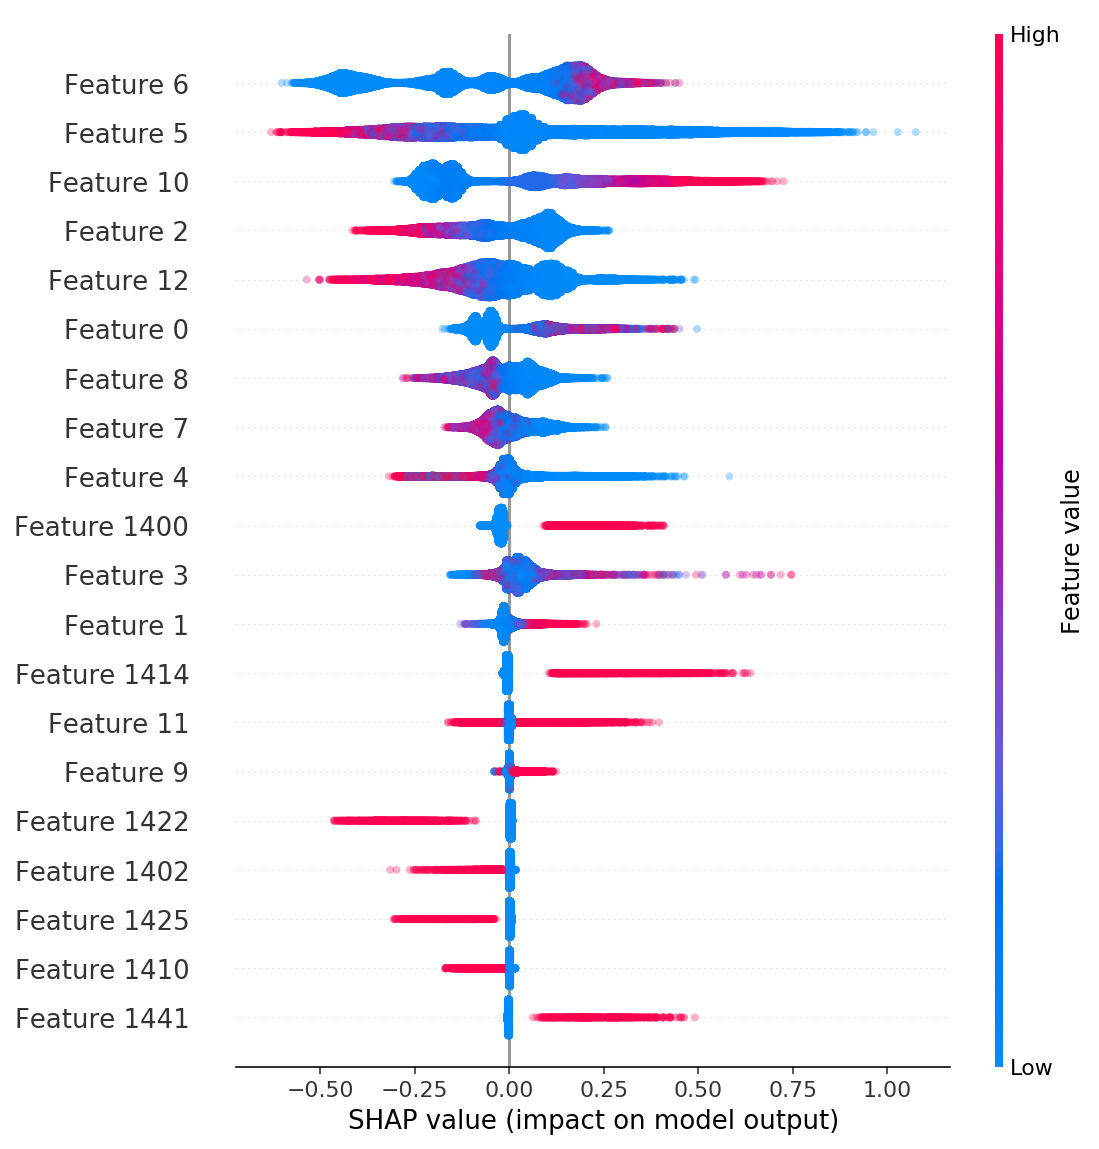

In [18]:
shap.summary_plot(shap_values, X_arr, max_display=20, alpha=0.3)

## [XGBoost features importance](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.Booster.get_score)

In [19]:
def get_feature_score(booster, importance):
    gains_xgb = booster.get_score(importance_type=importance)
    gains = {}
    for f, g in gains_xgb.items():
        gains[f] = g
    sorted_gains = sorted(list(gains.items()), key=lambda x: -x[1])
    return sorted_gains


features_scores = get_feature_score(bst, 'gain')[:20]

In [21]:
import pandas as pd


f_names, f_scores = zip(*features_scores)
features_scores_pdf = pd.DataFrame({'feature': f_names, 'gain': f_scores})

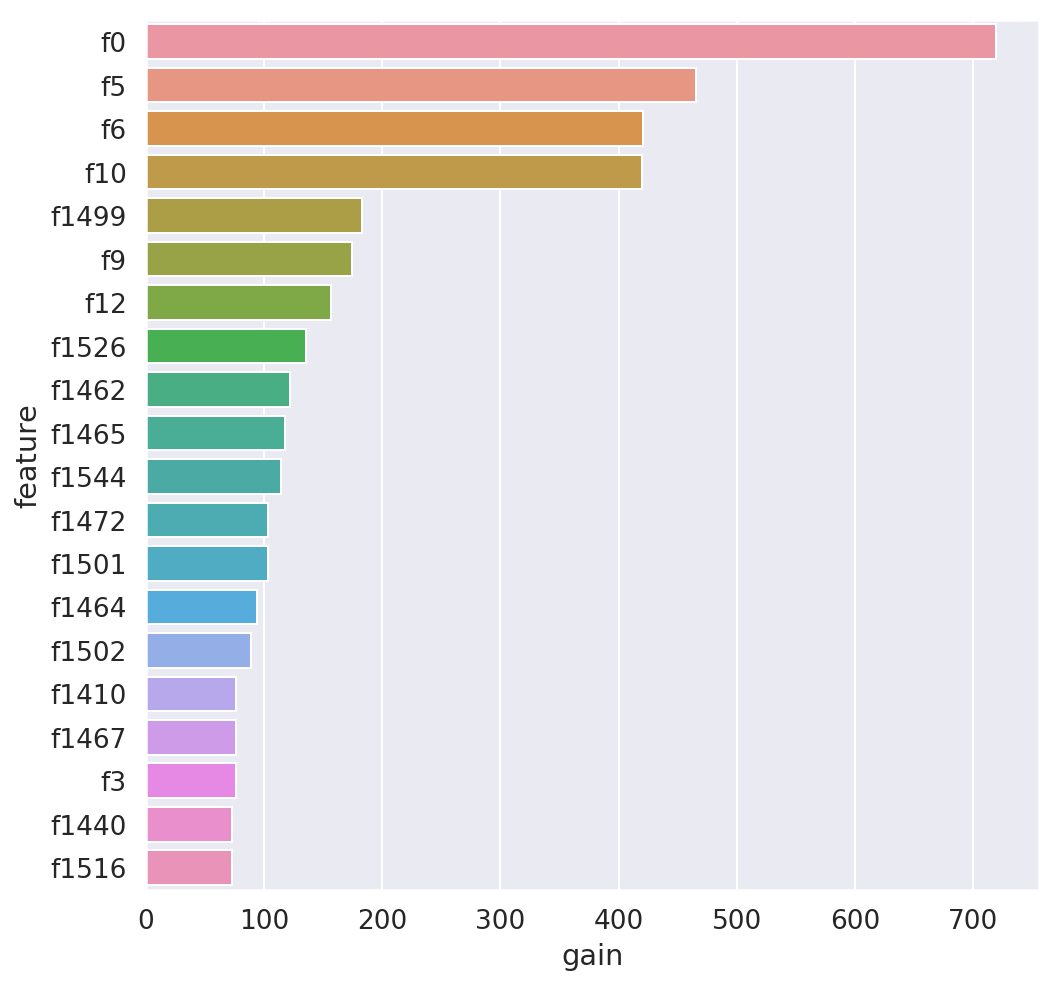

In [25]:
import seaborn as sns


_, ax = plt.subplots(figsize=(8,8))
ax = sns.barplot(x='gain', y='feature', data=features_scores_pdf)
plt.show()

# [Practical Lessons From Facebook](https://quinonero.net/Publications/predicting-clicks-facebook.pdf)

## Prepare Data

Реализуйте модель из статьи (LogReg поверх XGBoost)

In [36]:
######################################
######### YOUR CODE HERE #############
######################################

## Train

In [ ]:
######################################
######### YOUR CODE HERE #############
######################################

## Evaluation

In [35]:
def calibration(model, df):
    ######################################
    ######### YOUR CODE HERE #############
    ######################################
    pass

Сравните новую модель со всеми предыдущими с помощью `get_ate`. При сравнении использовать еще и метрику calibration

In [ ]:
######################################
######### YOUR CODE HERE #############
######################################

### Make a Submission

Если в результате работы получилась модель, которая лучше чем ЛогРег из предыдущей практики, то точно нужно сделать submission.